# Catégoriser automatiquement des questions : OC projet 6 #

## Traitement de notre problématique: Modélisation par une approche non supervisée  ##

Après avoir exploré notre jeu de données et procédé au nettoyage du jeu de données, nous allons dans cette première partie commencer par une approche non supervisée afin de déterminer notre capacité à tagger les questions en cohérence avec les tags rentrés en manuel par l'utilisateur. Afin de réaliser cette approche, nous allons utiliser deux méthodes d'exploration non supervisée de données textuelles classique : l'algorithme LDA pour LatentDirichletAllocation et l'algorithme NMF. Ces deux algorithmes sont basés sur un décomposition des données textuelles en bag of words sur la forme d'une matrice de vobulaire où l'on va compter la fréquence des mots (approche fréquence de mots suivi de l'algorithme LDA) et une matrice où l'on comtera la fréquence des mots respectives à leur apparition dans les différents documents (tf_idf suivi d'une réduction dimensionelle par une opération de factorisation matricielle particulière, la NMF).


## Importation de notre jeu de données ##

Nous récupérerons directement le jeu de données issu des traitements de notre exploration de données.

## I - Importation des librairies: ##

In [108]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.sklearn

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from IPython.core.display import Image, display, HTML

In [5]:
def line_treatment(line, list_words, tokenizer):
    """ Fonction qui traite une liste de mots en entrée
    et ressort un bag of words avec RegexTokenizer
    """
    list_to_include = []
    list_to_drop = []
    line = line.lower()
    for mot in list_words:
        if(mot in line.lower()):
            list_to_include.append(mot)
            list_to_drop.append(tokenizer.tokenize(mot)[0])
    
    vocab = tokenizer.tokenize(line)
    
    for inc in list_to_include:
        for w in vocab:
            if(w == tokenizer.tokenize(inc)[0]):
                vocab.remove(w)
                vocab.append(inc)
    return vocab

In [6]:
def remove_stopwords(vocab):
    """ Fonction qui traite les stopwords
    contenues dans la chaine de mots vocab
    """
    total_list = list(stopwords.words("English"))
    custom_list = ["to", "use", "can", "the", "get", "is", "doe", "way", "two"
                  "one", "an", "there", "are", "new", "like", "using", "vs", "without"]
    total_list = total_list + custom_list
    vocab_copy = vocab.copy()
    for w in vocab:
        if w in total_list:
            vocab_copy.remove(w)
    vocab_copy2 = vocab_copy.copy()
    for w in vocab_copy:
        if len(w) < 2:
            vocab_copy2.remove(w)
    return vocab_copy2

In [7]:
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

In [8]:
def lemm_fonction(tokens):
    """ Fonction qui renvoie une liste lemmatizer"""
    lemm = []
    lemmatizer = WordNetLemmatizer()
    tagged = nltk.pos_tag(tokens)
    for word, tag in tagged:
        wntag = get_wordnet_pos(tag)
        if wntag is None:# not supply tag in case of None
            lemma = lemmatizer.lemmatize(word) 
        else:
            lemma = lemmatizer.lemmatize(word, pos=wntag)
        if wntag == wordnet.NOUN:
            lemm.append(lemma)
    return lemm

In [9]:
def tokenizer_idf(text):
    """Tokenizer traitant nos données d'entrée de tf_idf
    """
    capwork_tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
    list_words_to_keep = [".net", "c++", "c#","sql-server", "asp.net", 
                          'ruby-on-rails', 'objective-c', 'visual-studio']
    stemmer = SnowballStemmer("english")
    response = line_treatment(text, list_words_to_keep, capwork_tokenizer)
    #response2 = [stemmer.stem(w) for w in response]
    response3  = lemm_fonction(response)
    return remove_stopwords(response3)

In [10]:
def count_null(df, x):
    """Fonction qui compte le % de données nulles
    dans la colonne x d'un tableau df
    """
    a = round((df[x].count() / table_raw.shape[0] * 100), 2)
    return float("%.2f" % a)

In [11]:
def print_top_words(model, feature_names, n_top_words):
    """ Fonction qui renvoie les mots les plus fréquents
    d'un theme identifié par model avec son dictionnaire
    feature_name
    s"""
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [157]:
def get_rwk(lamb, phi, pw):
    """ Fonction renvoyant la relevance des mots
    contenu dans ne vocabulaire
    """
    rw = np.array(phi)
    temp = np.array(phi)
    temp2 = np.array(pw)
    for w in range(temp.shape[1]):
        for k in range(temp.shape[0]):
            rw[k, w] = lamb * np.log(temp[k, w]) + (1-lamb) * np.log(temp[k, w] / temp2[w][0])
    return rw

In [13]:
def return_relevant_tags(topic, feature_names, rwk, n_top_words):
    """ Fonction qui renvoie les mots les plus adéquates 
    en fonction du rwk et du topic prédit
    """
    relevance = np.array(rwk)
    list_tags = list()
    for i in relevance[topic, :].argsort()[-1: -n_top_words: -1]:
         list_tags.append(feature_names[i])
    # message = "Topic #%d: " % topic
    #message += " ".join([feature_names[i] for i in relevance[topic, :].argsort()[-1: -n_top_words: -1]])
    #list_tags.append(message) 
    return list_tags

In [14]:
def return_main_topic(model_out):
    """ Fonction qui renvoie le topic prédit
    en allant chercher le thème majoritaire
    model_out
    """
    list_topics = list()
    for index, probabilities in enumerate(model_out):
        list_topics.append(probabilities.argsort()[-1])
    return list_topics

In [102]:
def get_tagging_score(y_tag_true, y_tag_predit):
    """ Fonction qui renvoie le nombre de tags vrai
    prédit dans la liste prédite"""
    score_test = list()
    for (x, y) in zip(y_tag_true, y_tag_predit):
        score_test.append(len(set(x) & set(y))/len(set(x)))
    return sum(score_test)/len(score_test)

## Fonction d'évaluation de la qualité des tags obtenus : ##

Afin d'évaluer la qualité des tags obtenue, nous allons les comparer aux tags remplis par les utilisateurs. Afin d'évaluer la précision du tagging obtenu par une approche supervisée, nous utiliserons une fonction qui comparera le nombre de tags pertinent (nous fournirons 5) fourni en commun avec les tags remplis. 

Ci-joint un exemple de score obtenu en comparant des listes de tags :

In [278]:
get_tagging_score([["unit","testing","jsp"]],[["java","eclipse","jsp"]])

0.3333333333333333

In [280]:
get_tagging_score([["python","test","foo"]],[["python","object","foo"]])

0.6666666666666666

## Exploration non supervisée en utilisant la méthode Latent Dirichlet Allocation : ##

Approche retenue:

- transformation de notre corpus de document sous format vectoriel grâce à la fonction CountVectorizer, avec un pré-traitement des mots réalisés avec notre propre tokenizer. On retiendra uniquement dans notre vocabulaire les mots présents dans au moins 0.1 % des documents et dans au maximum 30% des documents. Ce premier modèle considéra uniquement les mots de manière unigrammes.
- Nous exploiterons les possibilités de la fonction GridSearchCV afin d'optimiser la vraisemblance du modèle en fonction du nombre de thèmes retenus et du paramètre learning du modèle LDA. Une fois ces critères identifiés, nous ferons converger l'algorithme avec un nombre d'itérations importants afin d'assurer la convergence de l'algorithme en fonction de la pertinence des résultats des thèmes obtenus. Nous visualiserons ces thèmes à l'aide de l'outil pyLDAvis afin de mieux comprendre les thèmes identifiés.

### Transformation de notre texte en bag of words à partir de la fréquence d'apparitions des mots : ###

In [2]:
table_travail = pd.read_json("table_model.json")
bow_tags = [y for x in table_travail["Tags"] 
            for y in x]
f_dist_tags = nltk.FreqDist(bow_tags)
bow_bodytitle = [y for x in table_travail["BodyTitle"] 
                 for y in tokenizer_idf(x)]
f_dist_bodytitle = nltk.FreqDist(bow_bodytitle)

In [3]:
# Définition des paramètres min_df et max_df obtenus par fine-tuning.
word_min_lda = 0.001
word_max_lda = 0.3

In [15]:
# Définition de la fonction CountVectorizer
C_vect = CountVectorizer(input="content", stop_words="english", 
                         tokenizer=tokenizer_idf, 
                         min_df=word_min_lda, max_df=word_max_lda)

In [16]:
# Transformation de notre corpus de documents.
tf = C_vect.fit_transform(table_travail["BodyTitle"])

In [1]:
stat1 = len(set(list(f_dist_tags)) & set(C_vect.vocabulary_))/len(set(list(f_dist_tags)))*100
print(f"{round(stat1, 2)} % des tags sont présents dans le vocabulaire")

NameError: name 'f_dist_tags' is not defined

In [285]:
len(set(list(f_dist_tags)) & set(C_vect.stop_words_))/len(set(list(f_dist_tags)))*100

40.77984625358896

In [286]:
len(set(list(f_dist_tags)) & set(list(f_dist_bodytitle)))/len(set(list(f_dist_tags)))*100

50.50476984347504

In [20]:
y_tags = table_travail[["Title","Tags"]]

### Séparation de notre jeu de données et d'entrainements : ###

Nous séparerons ici nos données en jeu d'entrainement et jeu de test : 

In [21]:
tf_train, tf_test, y_lda_tags_train, y_lda_tags_test  = train_test_split(tf, y_tags, test_size=0.3)

### Validation croisée : ###

Au cours de la validation croisée, nous ferons varier les thèmes de 14 à 26 et le paramètre learning_decay entre 0.5, 0.75 et 1.

In [207]:
grid_param = {"n_components":[14, 16, 18, 20, 22, 24, 26], 
              "learning_decay":[0.5, 0.75, 1], 
              "learning_method":["online"]}
lda = LatentDirichletAllocation(n_jobs=-1)
lda_model = GridSearchCV(lda, grid_param, cv=5, return_train_score=True)

In [208]:
lda_model.fit(tf_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [14, 16, 18, 20, 22, 24, 26], 'learning_decay': [0.5, 0.75, 1], 'learning_method': ['online']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### Résultats visuels de notre validation croisée : ###

In [210]:
print("Best Model's Params: ", lda_model.best_params_)

Best Model's Params:  {'learning_decay': 0.75, 'learning_method': 'online', 'n_components': 20}


In [211]:
print("Best Log Likelihood Score: ", lda_model.best_score_)

Best Log Likelihood Score:  -1639751.05921


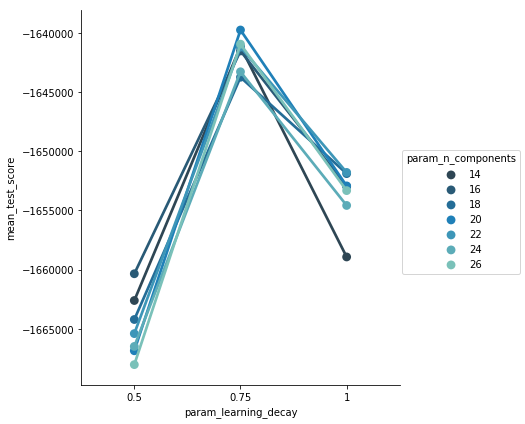

In [212]:
df_results = pd.DataFrame(lda_model.cv_results_)[["mean_test_score",
                                                "param_learning_decay",
                                                "param_n_components"
                                                 ]]
sns.factorplot(x="param_learning_decay", y="mean_test_score", hue="param_n_components", 
               data=df_results, capsize=.2, 
               palette="YlGnBu_d", size=6, aspect=1)
plt.show()

** Figure 001:** Résultats de notre validation croisée sur le jeu de données. On observe un maximum de vraisemblance pour 20 thèmes et un paramètre learning_decay de 0.75.

### Réentrainement du modèle sélectionné: ###

Nous allons réentrainer l'algorithme LDA avec un nombre d'itérations plus important afin d'assurer la convergence de l'algorithme. Nous évaluerons par la suite les résultats obtenus sur le jeu de test.

In [213]:
lda_final = LatentDirichletAllocation(n_jobs=-1, **lda_model.best_params_, 
                                      max_iter=1000).fit(tf_train)

In [294]:
lda_output = lda_final.transform(tf_test)

### Visualisation des thèmes dominants par documents : ###

Pour chacun des thèmes, nous allons afficher les mots clés (les plus fréquents) associés aux différents thèmes afin d'identifier la pertinence des 20 thèmes trouvée par la méthode LDA.

In [295]:
print_top_words(lda_final, C_vect.get_feature_names(), 15)

Topic #0: line command button script file bar branch foo address git change execution limit shell dir
Topic #1: table id database data field view model query column row sql index controller mysql db
Topic #2: server .net service client application web asp.net request http com connection site access mvc password
Topic #3: function time data event php date post code json var range return result cache hash
Topic #4: class int interface function void char base type return pointer node const member parent child
Topic #5: text log state search document box google status comment django engine root textbox debug cursor
Topic #6: page html javascript div jquery text style http tag element id browser cs title form
Topic #7: java string xml character apache eclipse expression package import jar org target com sun source
Topic #8: test control resource key unit window person assembly report tab wpf code validation xaml schema
Topic #9: method object class property string exception code return self

** Figure 002: ** Certains thèmes sont identifiables facilement (thème 1 avec les bases de données, thème 6 avec la programmation front-end). Nous allons continuer cette exploration en utilisant l'outil pyLDAvis et réorganisant ces mots par le critère "relevance" développé dans cet outil.

### Construction d'une fonction renvoyant les mots les plus pertinents :###

Nous allons calculer le critère relevance pour chaque mot associé à chaque thème afin de choisir au mieux la liste des mots allant servir de tags pour chacun des thèmes identifiés par l'algorithme LDA.

In [296]:
topic_name = ["Topic :" + str(i) for i in range(lda_final.n_components)]
phi_w_k = pd.DataFrame(data = lda_final.components_.copy(), index = topic_name, 
                       columns = C_vect.get_feature_names())
freq_features = np.array(tf.sum(axis=0))[0]
pw = pd.DataFrame(data=freq_features, index=C_vect.get_feature_names())

In [297]:
transfo = np.array(phi_w_k)
for i in range(len(phi_w_k.index)):
    somme_ligne = transfo[i,:].sum()
    transfo[i,:] = transfo[i,:] / somme_ligne

phi_w_k = pd.DataFrame(data = transfo, index = topic_name, 
                       columns = C_vect.get_feature_names())

In [298]:
rwk = pd.DataFrame(index=topic_name, columns=C_vect.get_feature_names(), 
                   data=get_rwk(0.66, phi_w_k, pw))

In [299]:
for i in range(20):
    print(list(rwk.columns[np.array(rwk)[i,:].argsort()][-1:-10:-1]))

['line', 'command', 'button', 'script', 'bar', 'branch', 'foo', 'git', 'file']
['table', 'database', 'id', 'field', 'query', 'model', 'column', 'view', 'data']
['server', 'service', '.net', 'client', 'asp.net', 'web', 'request', 'connection', 'http']
['function', 'event', 'php', 'date', 'time', 'data', 'post', 'json', 'range']
['int', 'class', 'interface', 'char', 'base', 'void', 'pointer', 'const', 'node']
['log', 'state', 'search', 'text', 'box', 'document', 'google', 'status', 'comment']
['page', 'html', 'javascript', 'div', 'jquery', 'style', 'tag', 'text', 'cs']
['java', 'string', 'xml', 'character', 'eclipse', 'apache', 'expression', 'package', 'jar']
['test', 'control', 'resource', 'unit', 'assembly', 'person', 'key', 'report', 'tab']
['method', 'object', 'property', 'class', 'exception', 'self', 'session', 'string', 'instance']
['file', 'image', 'header', 'color', 'layout', 'mode', 'content', 'cell', 'png']
['value', 'array', 'type', 'difference', 'lib', 'core', 'socket', 'enum

In [305]:
response_df = y_lda_tags_test.copy()
response_df.reset_index(inplace=True)

In [ ]:
list_predicted_topics = return_main_topic(lda_output)

In [309]:
response_df["predicted_topic"] = list_predicted_topics

In [310]:
response_df.head(5)

,index,Title,Tags,predicted_topic,predicted_tags,Topic :0,Topic :1,Topic :2,Topic :3,Topic :4,...,Topic :10,Topic :11,Topic :12,Topic :13,Topic :14,Topic :15,Topic :16,Topic :17,Topic :18,Topic :19
0,41445,"How to implement one ""catch'em all"" exception ...","[c#, exception]",9,"[method, object, property, class]",0.003333,0.071302,0.003333,0.076156,0.003333,...,0.003333,0.003333,0.003333,0.181353,0.003333,0.070000,0.003333,0.003333,0.148073,0.003333
1,53764,How to implement a file download in ASP.NET AJAX,"[asp.net-ajax, download]",10,"[file, image, header, color]",0.001471,0.001471,0.176591,0.066565,0.001471,...,0.296944,0.001471,0.044627,0.001471,0.001471,0.063226,0.001471,0.001471,0.001471,0.001471
2,41294,Best web front-end for SVN?,"[svn, version-control]",16,"[project, version, file, directory]",0.001786,0.041383,0.174230,0.050383,0.001786,...,0.038742,0.037500,0.057112,0.217067,0.001786,0.001786,0.288627,0.001786,0.001786,0.038612
3,28626,The difference between declaring a variable as...,"[php, variables]",0,"[line, command, button, script]",0.280556,0.002778,0.002778,0.113286,0.002778,...,0.002778,0.212153,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778
4,14730,Membership.ValidateUser always returns false a...,"[c#, asp.net, oracle, asp.net-membership]",2,"[server, service, .net, client]",0.002381,0.002381,0.478731,0.002381,0.002381,...,0.002381,0.002381,0.058715,0.241880,0.002381,0.124040,0.002381,0.002381,0.002381,0.060920


In [311]:
response_df["predicted_tags"] = \
response_df["predicted_topic"].apply(lambda x: 
                                         return_relevant_tags(x, C_vect.get_feature_names(), rwk, 5))

In [312]:
for i in range(len(topic_name)):
    response_df[topic_name[i]] = lda_output[:,i]

In [315]:
response_df[response_df["predicted_topic"] == 1][response_df.columns[0:5]]

,index,Title,Tags,predicted_topic,predicted_tags
11,56304,MySQL indices and order,"[mysql, indexing, sql-order-by]",1,"[table, database, id, field]"
12,52561,varchar vs. mediumtext,"[mysql, text, varchar]",1,"[table, database, id, field]"
23,28787,How to efficiently use MySQLDB SScursor?,"[python, mysql, optimization, cursor]",1,"[table, database, id, field]"
29,40155,How to set a GUID as ADO query parameters from...,"[delphi, guid, ado]",1,"[table, database, id, field]"
43,6792,Am I immune to SQL injections if I use stored ...,"[database, security, stored-procedures, sql-in...",1,"[table, database, id, field]"
53,37518,Implementing IEnumerable,"[linq-to-sql, generics]",1,"[table, database, id, field]"
58,15196,SELECT FOR UPDATE with SQL Server,"[sql, sql-server, sql-server-2005, tsql, read-...",1,"[table, database, id, field]"
67,57230,Entity Framework Guid,"[c#, asp.net, entity-framework]",1,"[table, database, id, field]"
125,47487,How do you transform a Linq query result to XML?,"[c#, linq, linq-to-xml]",1,"[table, database, id, field]"
128,19163,How to return the value of AUTO INCREMENT colu...,"[sqlite, vb6, auto-increment]",1,"[table, database, id, field]"


In [317]:
get_tagging_score(response_df["Tags"], response_df["predicted_tags"])

0.05173965660691397

In [318]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_final, tf_train, C_vect, mds='tsne')
pyLDAvis.save_html(panel, 'lda.html')

## Exploration non supervisée en utilisant la méthode PLSI : ##

La méthode PLSI est équivalente a utilisé un algorithme NMF sur une transformation tf_idf sur notre corpus de document.

### Transformation de nos données textuelles en données numériques à l'aide de tf-idf : ###

La première étape consiste donc à appliquer dans un premier temps une transformation en matrice de mots de nos documents avec un coefficient reflétant la fréquence de mots respective à leur fréquence d'apparition dans les documents. Le nombre de thème choisi sera similaire à celui du modèle LDA.


In [252]:
nb_topics_nmf = lda_model.best_params_["n_components"]
word_min_nmf = 0.001
word_max_nmf= 0.3

In [253]:
tf_vectorizer = TfidfVectorizer(input='content', stop_words="english", tokenizer=tokenizer_idf, 
                                min_df=word_min_nmf, max_df=word_max_nmf)

In [254]:
doc = tf_vectorizer.fit_transform(table_travail["BodyTitle"])

In [319]:
len(set(list(f_dist_tags)) & set(tf_vectorizer.vocabulary_))/ len(set(list(f_dist_tags))) * 100

9.6045197740113

In [320]:
len(set(list(f_dist_tags)) & set(tf_vectorizer.stop_words_))/ len(set(list(f_dist_tags))) * 100

40.77984625358896

In [321]:
len(set(list(f_dist_tags)) & set(list(f_dist_bodytitle)))/len(set(list(f_dist_tags))) * 100

50.50476984347504

In [257]:
y_tags_nmf = table_travail[["Title","Tags"]]

### Séparation de notre jeu de données en données d'entrainement et données de test : ###

In [258]:
tfidf_train, tfidf_test, y_tags_train, y_tags_test  = train_test_split(doc, y_tags, test_size=0.3)

### Application de l'algorithme NMF et interprétation des résultats obtenus : ###

In [259]:
nmf = NMF(n_components=nb_topics_nmf, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.5,
          l1_ratio=1).fit(tfidf_train)

In [260]:
print_top_words(nmf, tf_vectorizer.get_feature_names(), 10)

Topic #0: example thanks question case problem idea answer thing edit help
Topic #1: file directory path folder command copy configuration machine version error
Topic #2: class method function code object int java foo void instance
Topic #3: value string array function example character int number key result
Topic #4: function javascript page jquery code browser button document click link
Topic #5: c++ code language library bit program memory time compiler performance
Topic #6: database table sql column query server data mysql row db
Topic #7: image size color background text width height http png position
Topic #8: list item order collection element structure group index set linq
Topic #9: value control property default studio custom code option assembly wpf
Topic #10: .net application asp.net access web service mvc app framework user
Topic #11: application java app window event user api iphone button thanks
Topic #12: html element id content page cs div tag class document
Topic #13: 

** Figure 003: ** Les résultats obtenus sont relativement similaires à l'algorithme LDA, certains peuvent facilement interpréter, d'autres sont plus difficiles à interpréter.

In [261]:
response_nmf = nmf.transform(tfidf_test)

In [323]:
response_df_nmf = y_tags_test.copy()
response_df_nmf.reset_index(inplace=True)
response_df_nmf["predicted_topics"] = return_main_topic(response_nmf)
response_df_nmf["nmf_tags"] = \
response_df_nmf["predicted_topics"].apply(lambda x: 
                                          return_relevant_tags(x, tf_vectorizer.get_feature_names(), 
                                                               nmf.components_, 5))

In [326]:
response_df_nmf.head(5)

,index,Title,Tags,predicted_topics,nmf_tags
0,43200,Detect system standby/sleep/hibernate from .NE...,"[c#, .net, windows-services, power-state]",11,"[application, java, app, window]"
1,42265,My pay pal button will not link to pay pal. It...,"[asp.net, vb.net, paypal, paypal-buttons]",12,"[html, element, id, content]"
2,54896,Does RubyMine 2.0 earn its $99 as a Rails IDE?,"[ruby-on-rails, ide, rubymine]",16,"[method, object, view, model]"
3,19767,Java GUI and Multiple Instances of the SwingWo...,"[java, user-interface, swing, swingworker]",11,"[application, java, app, window]"
4,49542,Is it ethical to monitor users?,"[security, tracking, privacy, corporate-policy]",0,"[example, thanks, question, case]"


In [327]:
get_tagging_score(response_df_nmf["Tags"], response_df_nmf["nmf_tags"])

0.058983813629832384

## Evaluation de nos algorithmes sur un jeu de test indépendant : ##

In [328]:
table_eval = pd.read_json("table_eval.json")

In [330]:
tf_eval = C_vect.transform(table_eval["BodyTitle"])
lda_eval = lda_final.transform(tf_eval)
table_eval["predicted_topics"] = return_main_topic(lda_eval)
table_eval["predicted_tags"] = \
table_eval["predicted_topics"].apply(lambda x: 
                                     return_relevant_tags(x, C_vect.get_feature_names(), rwk, 5))

In [341]:
table_eval.tail(15)

,Body,BodyTitle,CreationDate,Score,Tags,Title,predicted_topics,predicted_tags
9881,I thoroughly enjoy the amazing power of LINQPA...,Automatic way to move Visual Studio project in...,2010-11-10 20:10:45,4,"[visual-studio-2010, linqpad]",Automatic way to move Visual Studio project in...,16,"[project, version, file, directory]"
9889,"For my web application, I am creating a namesp...",How to create private variables within a names...,2010-11-10 20:21:48,8,"[javascript, namespaces, private-members]",How to create private variables within a names...,4,"[int, class, interface, char]"
9893,I'm using Python's csv module to do some readi...,Overwriting a specific row in a csv file using...,2010-11-10 20:30:23,5,"[python, csv]",Overwriting a specific row in a csv file using...,10,"[file, image, header, color]"
9920,I've been trying to get a JavaScript regex com...,Javascript camelCase to Regular Form I've been...,2010-11-10 21:30:59,119,"[javascript, regex]",Javascript camelCase to Regular Form,12,"[error, number, message, byte]"
9930,I am just starting to learn Ruby (to eventuall...,Does Ruby support unicode and how does it work...,2010-11-10 21:44:05,31,"[ruby, unicode]",Does Ruby support unicode and how does it work?,7,"[java, string, xml, character]"
9932,When my Activity with a ScrollView layout and ...,OnScreen keyboard opens automatically when Act...,2010-11-10 21:46:25,32,"[android, keyboard, focus, scrollview]",OnScreen keyboard opens automatically when Act...,10,"[file, image, header, color]"
9938,I want to display an image within an iframe on...,Displaying image in Iframe I want to display a...,2010-11-10 21:53:18,5,"[php, html, iframe]",Displaying image in Iframe,6,"[page, html, javascript, div]"
9941,Im pulling a date from a database which is for...,PHP Checking if the current date is before or ...,2010-11-10 22:03:57,27,[php],PHP Checking if the current date is before or ...,3,"[function, event, php, date]"
9951,Example A\nStudy the following snippet:\npubli...,Generics type inference fails? Example A\nStud...,2010-11-10 22:41:30,8,"[java, generics, type-inference]",Generics type inference fails?,9,"[method, object, property, class]"
9956,I know span strong and em. Are there any other...,XHTML - What elements are allowed within the <...,2010-11-10 22:48:42,18,"[html, xhtml, hyperlink, tags]",XHTML - What elements are allowed within the <...,6,"[page, html, javascript, div]"


In [338]:
get_tagging_score(table_eval["Tags"], table_eval["predicted_tags"])

0.04918302298272065